### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.head()

,con,focus,int,land_speed,fortitude,str,num_immunities,book,wis,hp,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,5,1,1,30.0,22,7,3,Pathfinder Bestiary,2,215,...,0,0,0,0,0,0,23,22.0,0,0.0
1,5,0,-4,35.0,21,9,0,Pathfinder Bestiary,2,220,...,0,0,0,0,0,0,23,22.0,0,0.0
2,6,0,-4,30.0,20,7,0,Pathfinder Bestiary,3,175,...,0,0,0,0,0,0,21,16.0,0,0.0
3,5,1,6,50.0,30,7,3,Pathfinder Bestiary,5,315,...,1,0,1,0,0,0,33,31.5,0,0.0
4,1,1,-1,0.0,6,-5,0,Pathfinder Bestiary,1,20,...,1,0,0,0,0,0,0,0.0,8,5.0


## Preprocessing and train test split

In [3]:
from sklearn.preprocessing import MinMaxScaler


columns = [col for col in df.columns if col not in ["book", "level"]]
scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[columns] = pd.DataFrame(scaler.fit_transform(df[columns]))
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]

In [4]:
min_max_df.head()

,con,focus,int,land_speed,fortitude,str,num_immunities,wis,hp,cha,...,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg,book,level
0,0.416667,0.333333,0.400000,0.250000,0.500000,0.705882,0.1875,0.333333,0.386447,0.3750,...,0.0,0.0,0.0,0.0,0.489362,0.385965,0.000000,0.000000,Pathfinder Bestiary,10
1,0.416667,0.000000,0.066667,0.291667,0.477273,0.823529,0.0000,0.333333,0.395604,0.3750,...,0.0,0.0,0.0,0.0,0.489362,0.385965,0.000000,0.000000,Pathfinder Bestiary,10
2,0.500000,0.000000,0.066667,0.250000,0.454545,0.705882,0.0000,0.416667,0.313187,0.1875,...,0.0,0.0,0.0,0.0,0.446809,0.280702,0.000000,0.000000,Pathfinder Bestiary,8
3,0.416667,0.333333,0.733333,0.416667,0.681818,0.705882,0.1875,0.583333,0.569597,0.6875,...,0.2,0.0,0.0,0.0,0.702128,0.552632,0.000000,0.000000,Pathfinder Bestiary,17
4,0.083333,0.333333,0.266667,0.000000,0.136364,0.000000,0.0000,0.250000,0.029304,0.3750,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.186047,0.081967,Pathfinder Bestiary,1


### Chronological split

In [5]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models/linear_regression")

In [6]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [7]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [8]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [9]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.43
RMSE test: 0.74
MSE test: 0.55
MAE test: 0.46


In [12]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_train.columns), mse, rmse, mae]

In [13]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.55
RMSE: 0.74

Round type: round
MSE: 0.42
RMSE: 0.65

Round type: 0.33
MSE: 0.41
RMSE: 0.64

Round type: 0.45
MSE: 0.42
RMSE: 0.65



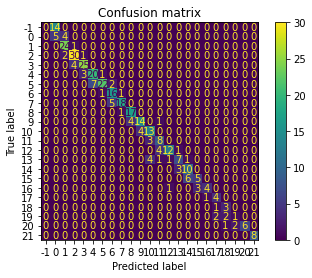

In [14]:
plot_confusion_matrix("round", predict, y_test)

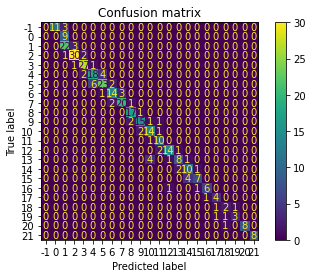

In [15]:
plot_confusion_matrix(0.33, predict, y_test)

### With random split

In [16]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)
predict_train = model.predict(X_train_random_split)
predict = model.predict(X_test_random_split)

y_pred_train = model.predict(X_train_random_split)
y_pred_test = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [17]:
rmse_train = mean_squared_error(y_train_random_split, y_pred_train, squared=False)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mse = mean_squared_error(y_test_random_split, y_pred_test)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MSE test: {mse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.44
RMSE test: 0.57
MSE test: 0.33
MAE test: 0.36


In [18]:
results.loc[1] = ["random", "normal", len(X_train.columns), mse, rmse, mae]

In [19]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, predict)

Normal:
MSE: 0.33
RMSE: 0.57

Round type: round
MSE: 0.23
RMSE: 0.48

Round type: 0.33
MSE: 0.30
RMSE: 0.55

Round type: 0.45
MSE: 0.24
RMSE: 0.48



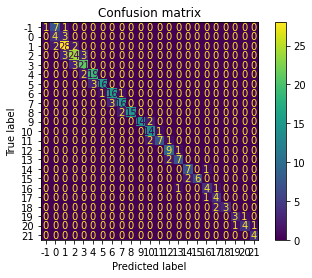

In [20]:
plot_confusion_matrix("round", predict, y_test_random_split)

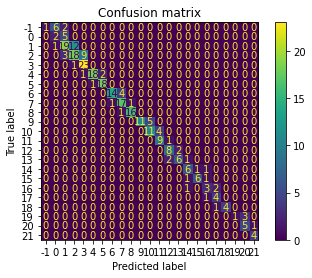

In [21]:
plot_confusion_matrix(0.33, predict, y_test_random_split)

## Tuning (ridge, LASSO)

### With chronological split

In [22]:
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV
from training.results import assess_regression_model


reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()

print("Linear Regression")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test, r2=True)

print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[2] = ["chronological", "Ridge", len(X_train.columns), mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[3] = ["chronological", "Lasso", len(X_train.columns), mse, rmse, mae]

Ridge CV alpha: 0.5000
Lasso CV alpha: 0.0023

Linear Regression
R2: 0.99
RMSE train: 0.43
RMSE test: 0.74
MSE test: 0.55
MAE test: 0.46

Ridge:
R2: 0.99
RMSE train: 0.43
RMSE test: 0.76
MSE test: 0.58
MAE test: 0.48

Lasso:
R2: 0.99
RMSE train: 0.45
RMSE test: 0.70
MSE test: 0.48
MAE test: 0.45



<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

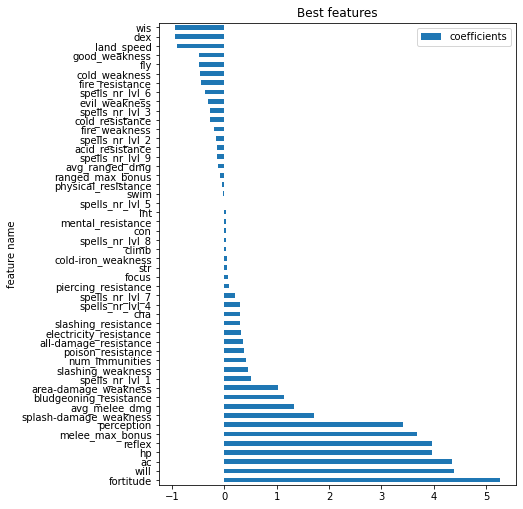

In [23]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [24]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

['acid_resistance',
 'area-damage_weakness',
 'avg_ranged_dmg',
 'climb',
 'cold-iron_weakness',
 'con',
 'electricity_resistance',
 'evil_weakness',
 'fire_weakness',
 'int',
 'mental_resistance',
 'physical_resistance',
 'piercing_resistance',
 'slashing_resistance',
 'spells_nr_lvl_2',
 'spells_nr_lvl_3',
 'spells_nr_lvl_5',
 'spells_nr_lvl_7',
 'spells_nr_lvl_8',
 'spells_nr_lvl_9',
 'str',
 'swim']

### With random split

In [25]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train_random_split, y_train_random_split)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train_random_split,
    np.array(y_train_random_split).reshape(
        y_train_random_split.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
rmse, mse, mae = assess_regression_model(
    reg_ridge_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[4] = ["random", "Ridge", len(X_train.columns), mse, rmse, mae]

print("Lasso:")
rmse, mse, mae = assess_regression_model(
    reg_lasso_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[5] = ["random", "Lasso", len(X_train.columns), mse, rmse, mae]

Ridge CV alphas: 0.2592
Lasso CV alpha: 0.0011

Ridge:
R2: 0.99
RMSE train: 0.45
RMSE test: 0.59
MSE test: 0.34
MAE test: 0.35

Lasso:
R2: 0.99
RMSE train: 0.45
RMSE test: 0.56
MSE test: 0.32
MAE test: 0.35



<AxesSubplot:title={'center':'Best features'}, ylabel='feature name'>

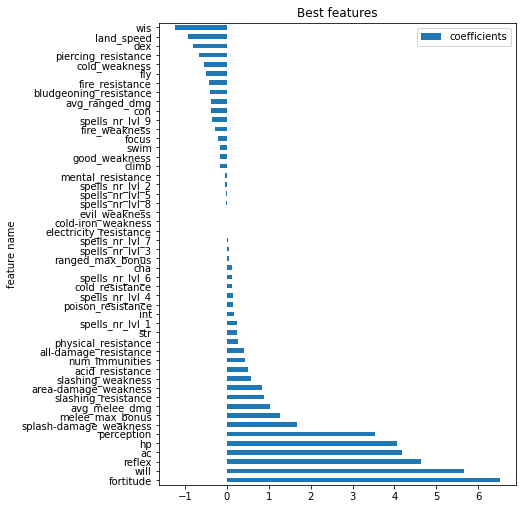

In [26]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [27]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

['area-damage_weakness',
 'cold-iron_weakness',
 'cold_resistance',
 'electricity_resistance',
 'evil_weakness',
 'mental_resistance',
 'spells_nr_lvl_2',
 'spells_nr_lvl_5',
 'spells_nr_lvl_6',
 'spells_nr_lvl_7',
 'spells_nr_lvl_8']

## Summary

In [28]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,50,0.551527,0.742648,0.457334
1,random,normal,50,0.328772,0.573386,0.356771
2,chronological,Ridge,50,0.580654,0.762007,0.475612
3,chronological,Lasso,50,0.484719,0.696218,0.454244
4,random,Ridge,50,0.342304,0.585067,0.354016
5,random,Lasso,50,0.315537,0.561727,0.349635


In [29]:
from training.results import plot_summary

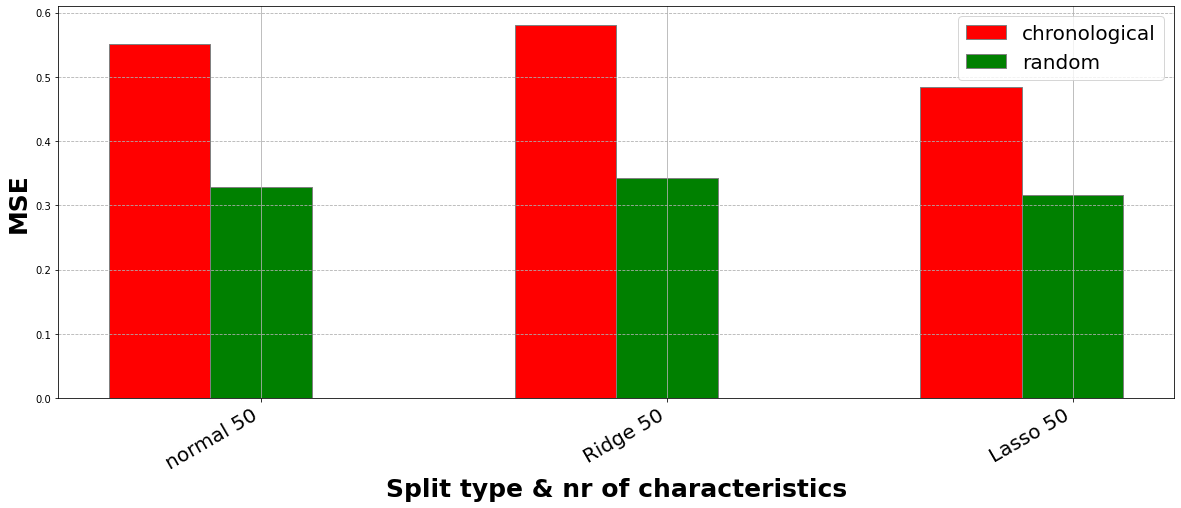

In [30]:
plot_summary(results, "MSE")

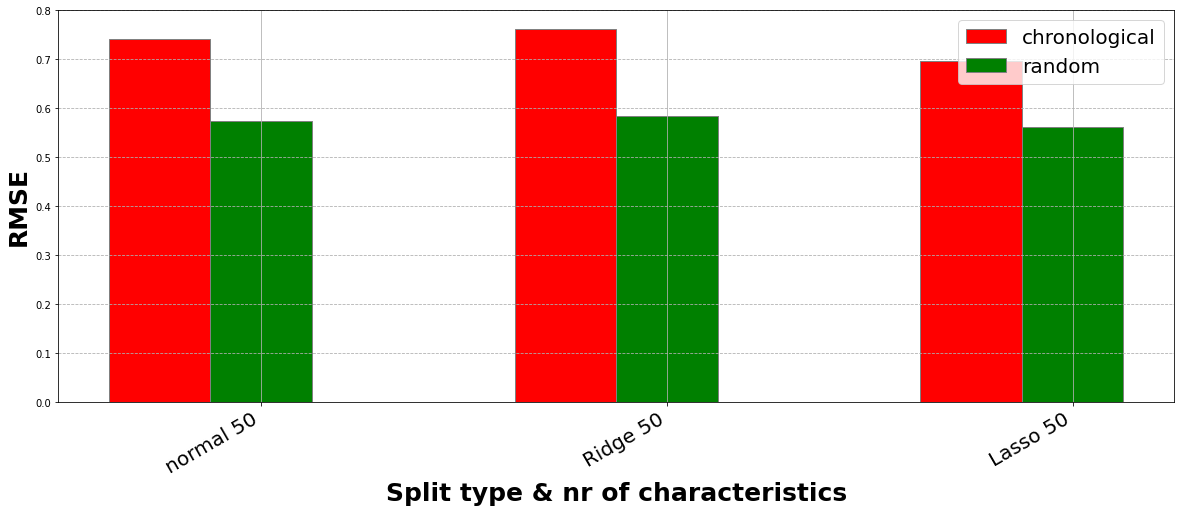

In [31]:
plot_summary(results, "RMSE")

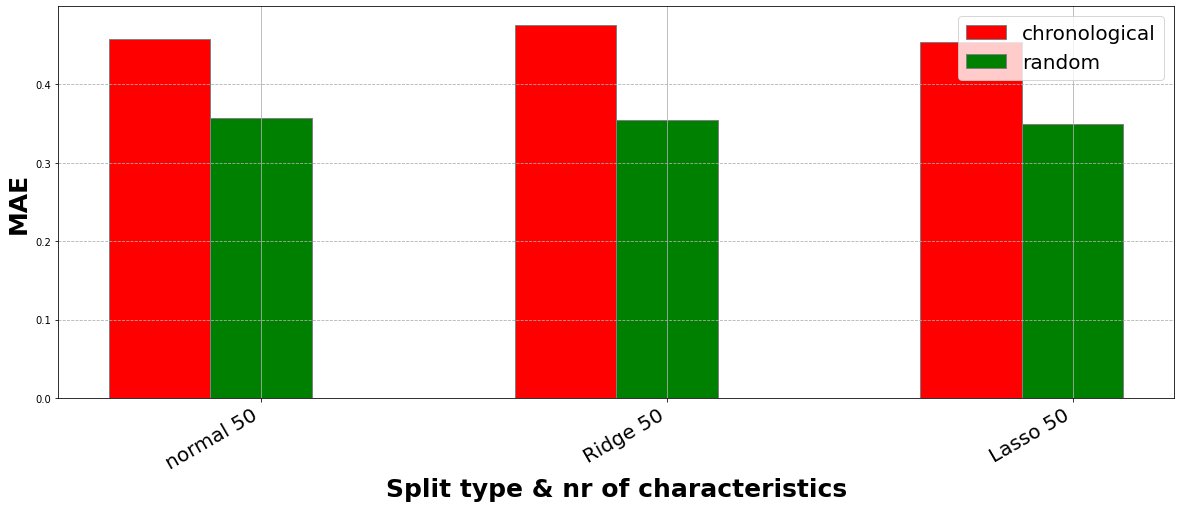

In [32]:
plot_summary(results, "MAE")

In [33]:
results.to_json("./linear_regression_final_results.json")